# Basic PyTorch Neural Network
Now it's time to put the pieces together. In this section we'll:
* create a multi-layer deep learning model
* load data
* train and validate the model<br>

We'll also introduce a new step:
* save and load a trained model

Our goal is to develop a model capable of classifying an iris plant based on four features. This is a multi-class classification where each sample can belong to ONE of 3 classes (<em>Iris setosa</em>, <em>Iris virginica</em> or <em>Iris versicolor</em>). The network will have 4 input neurons (flower dimensions) and 3 output neurons (scores). Our loss function will compare the target label (ground truth) to the corresponding output score.

<br><br>

<div class="alert alert-info"><strong>NOTE:</strong> Multi-class classifications usually involve converting the target vector to a one_hot encoded matrix. That is, if 5 labels show up as<br>
<pre style='background-color:rgb(217,237,247)'>tensor([0,2,1,0,1])</pre>
then we would encode them as:
<pre style='background-color:rgb(217,237,247)'>tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]])</pre>
This is easily accomplished with <a href='https://pytorch.org/docs/stable/nn.html#one-hot'><strong><tt>torch.nn.functional.one_hot()</tt></strong></a>.<br>
However, our loss function <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a> takes care of this for us.</div>

## Libray Imports

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_iris

## Load the dataset and visualize by target variable

In [2]:
data = load_iris()

# Convert this to a dataframe
df = pd.DataFrame(data=data.data, columns=data.feature_names)
# Add the target as another column
df['target'] = data.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


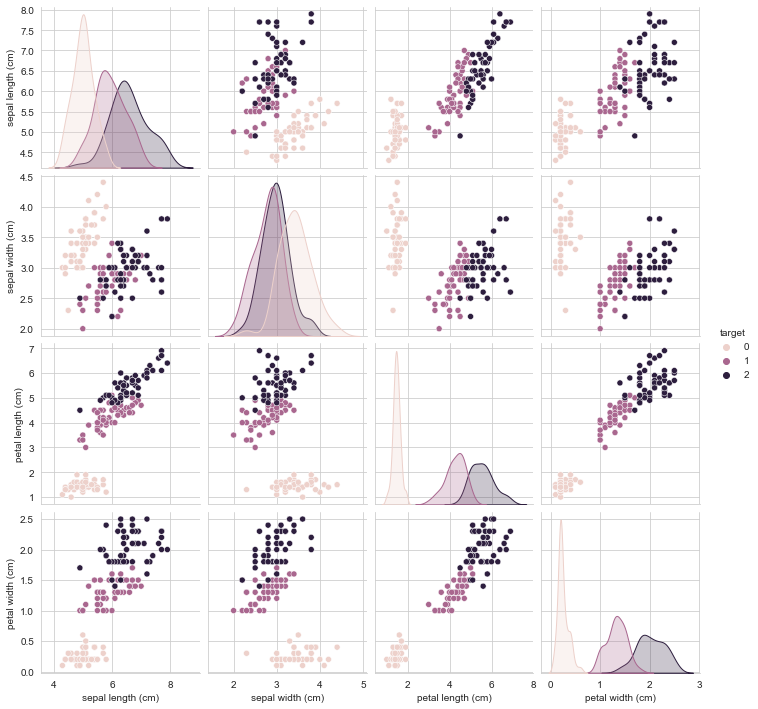

In [3]:
# Visualize by target variable
sns.pairplot(data=df, hue='target')

## Create a model class
For this exercise we're using the Iris dataset. Since a single straight line can't classify three flowers we should include at least one hidden layer in our model.

In the forward section we'll use the <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>rectified linear unit</a> (ReLU)  function<br>
$\quad f(x)=max(0,x)$<br>
as our activation function. This is available as a full module <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong><tt>torch.nn.ReLU</tt></strong></a> or as just a functional call <a href='https://pytorch.org/docs/stable/nn.html#id27'><strong><tt>torch.nn.functional.relu</tt></strong></a>

In [4]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        # How many layers
        # Input Layer (4 features) --> h1 --> h2 --> output (3 classes)
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1) # Input Layer
        self.fc2 = nn.Linear(h1, h2) # Hidden Layer
        self.out = nn.Linear(h2, out_features) # Output Layer

    def forward(self, x):
        x = fn.relu(self.fc1(x))
        x = fn.relu(self.fc2(x))
        x = self.out(x)
        return x

In [5]:
# Instantiate the model class using parameter defaults
torch.manual_seed(32)
model = Model()

In [8]:
# Lets view the summary of the model
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            40
├─Linear: 1-2                            81
├─Linear: 1-3                            30
Total params: 151
Trainable params: 151
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            40
├─Linear: 1-2                            81
├─Linear: 1-3                            30
Total params: 151
Trainable params: 151
Non-trainable params: 0

In [18]:
# To view the model paramters
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

## Performing a train-test split

In [19]:
features = df.drop(labels=['target'], axis=1).values
target = df['target'].values

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=33)
features_train = torch.FloatTensor(features_train)
features_test = torch.FloatTensor(features_test)
target_train = torch.LongTensor(target_train)
target_test = torch.LongTensor(target_test)

## Prepare DataLoader
For this analysis we don't need to create a Dataset object, but we should take advantage of PyTorch's DataLoader tool. Even though our dataset is small (120 training samples), we'll load it into our model in two batches. This technique becomes very helpful with large datasets.

Note that scikit-learn already shuffled the source dataset before preparing train and test sets. We'll still benefit from the DataLoader shuffle utility for model training if we make multiple passes throught the dataset.

In [20]:
trainloader = DataLoader(features_train, batch_size=60, shuffle=True)
testloader = DataLoader(features_test, batch_size=60, shuffle=False)

## Define loss equations and optimizations
As before, we'll utilize <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll use a variation of Stochastic Gradient Descent called <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (short for Adaptive Moment Estimation), with <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [11]:
# For REDO
torch.manual_seed(4)
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train the model

In [13]:
epochs = 100
losses = []

for index in range(epochs):
    index+=1
    target_pred = model.forward(features_train)
    loss = criterion(target_pred, target_train)
    losses.append(loss.item())

    # a neat trick to save screen space:
    if index%10 == 1:
        print(f'epoch: {index}  loss: {loss.item()}')

    # call backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 1  loss: 0.06087281554937363
epoch: 11  loss: 0.05792764201760292
epoch: 21  loss: 0.05581693351268768
epoch: 31  loss: 0.05419965833425522
epoch: 41  loss: 0.05290580168366432
epoch: 51  loss: 0.05183269828557968
epoch: 61  loss: 0.05091381445527077
epoch: 71  loss: 0.050104692578315735
epoch: 81  loss: 0.04937659949064255
epoch: 91  loss: 0.048710308969020844


### Plot the loss function

Text(0, 0.5, 'losses')

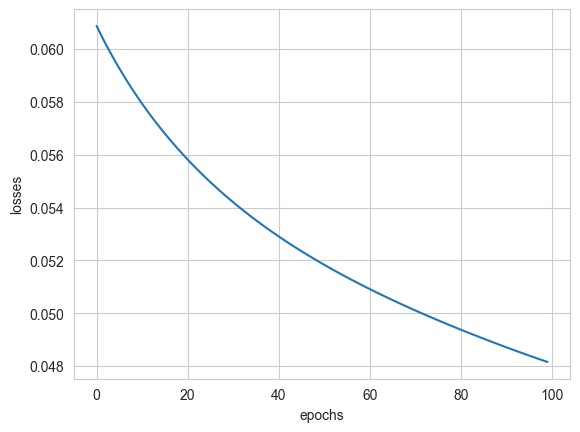

In [15]:
plt.plot(range(epochs), losses)
plt.xlabel('epochs')
plt.ylabel('losses')

## Validate the model

In [41]:
# to evaluate on the entire test set
with torch.no_grad(): # We just evaluate on test data and we dont perform backpropagation and change weights and biases, because the model is already trained
    target_pred = model.forward(features_test)
    loss = criterion(target_pred, target_test)
print(f"Loss on the test set - {loss}")

Loss on the test set - 0.044543616473674774


In [58]:
target_pred.numpy()

array([[ -0.58140427,   9.949995  ,   1.9008801 ],
       [  0.08582443,  11.046403  ,   0.9559836 ],
       [ 17.101864  ,   9.662893  , -25.880476  ],
       [ -2.7634246 ,  10.614578  ,   5.410825  ],
       [ -8.104266  ,  10.24094   ,  13.781658  ],
       [-14.6096115 ,  10.133774  ,  24.03469   ],
       [ 16.919928  ,   9.935265  , -25.604546  ],
       [ 18.358686  ,  10.110777  , -27.791552  ],
       [ -8.178724  ,  10.557719  ,  13.931835  ],
       [-11.230042  ,  10.805875  ,  18.77593   ],
       [-12.336149  ,  10.720025  ,  20.508402  ],
       [ 16.697124  ,   9.152657  , -25.267632  ],
       [-11.766394  ,  10.225834  ,  19.56194   ],
       [ -2.9308474 ,  10.337284  ,   5.640358  ],
       [ -8.713176  ,  10.695882  ,  14.806921  ],
       [  0.09243029,  10.6807375 ,   0.91156715],
       [ -5.844937  ,  10.026453  ,  10.209917  ],
       [ 18.666674  ,  10.28604   , -28.259228  ],
       [ -2.655874  ,  10.638685  ,   5.233746  ],
       [ -8.915651  ,  11.48430

In [52]:
# target_pred does predictions for all classes
target_pred[0].argmax().item()

1

In [53]:
# to get particular class, we need to do an argmax and get the item
predictions = []
for index in range(len(target_pred)):
    predictions.append(target_pred[index].argmax().item())

In [59]:
print("Classification Report")
print(classification_report(target_test.numpy(), predictions))
print("\n")
print("Confusion Matrix")
print(confusion_matrix(target_test.numpy(), predictions))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Confusion Matrix
[[ 8  0  0]
 [ 0  8  0]
 [ 0  0 14]]


## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [61]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

### Load a new model
We'll load a new model object and test it as we had before to make sure it worked.

In [69]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt')) # This saves only the weights and biases not the entire model class
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [63]:
with torch.no_grad():
    y_val = new_model.forward(features_test)
    loss = criterion(y_val, target_test)
print(f"Loss - {loss}")

Loss - 0.044543616473674774


## Apply the model to classify new unseen data

In [64]:
mystery_iris = torch.tensor([5.6, 3.7, 2.2, 0.5])

We will now run it through the model

In [68]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print('The label is ')
    print(new_model(mystery_iris).argmax().item())

tensor([ 16.3226,  10.6901, -24.6825])
The label is 
0
